# Simulation using Concord

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import pandas as pd

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}


In [8]:
proj_name = "simulation_result_integration"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Aug25-1649'

In [9]:
result_path = {
    'cluster_fullcover_batchratio_1': '../save/dev_simulation_cluster_imbalancep1-Jul29/benchmarks_out/benchmark_results_Jul29-1352_1.pkl',
    'cluster_fullcover_batchratio_5': '../save/dev_simulation_cluster_imbalancep1-Jul29/benchmarks_out/benchmark_results_Jul29-1352_5.pkl',
    'cluster_fullcover_batchratio_20': '../save/dev_simulation_cluster_imbalancep1-Jul29/benchmarks_out/benchmark_results_Jul29-1352_20.pkl',
    'cluster_partialcover_batchnum_2': '../save/dev_simulation_cluster_imbalancep2-Jul29/benchmarks_out/benchmark_results_Jul29-2214_2_batches.pkl',
    'cluster_partialcover_batchnum_10': '../save/dev_simulation_cluster_imbalancep2-Jul29/benchmarks_out/benchmark_results_Jul29-2214_10_batches.pkl',
    'cluster_partialcover_batchnum_30': '../save/dev_simulation_cluster_imbalancep2-Jul29/benchmarks_out/benchmark_results_Jul29-2214_30_batches.pkl',
    'trajectory_full': '../save/dev_simulation_trajectory-Aug25/benchmarks_out/benchmark_results_Aug25-1536.pkl', 
    'trajectory_partial': '../save/dev_simulation_trajectory_partial-Aug25/benchmarks_out/benchmark_results_Aug25-1537.pkl',
    'trajectory_connected' : '../save/dev_simulation_trajectory_connected-Aug25/benchmarks_out/benchmark_results_Aug25-1537.pkl',
    'trajectory_varybatch' : '../save/dev_simulation_trajectory_varybatch-Aug25/benchmarks_out/benchmark_results_Aug25-1520.pkl', 
    'loop_full' : '../save/dev_simulation_oneloop_full-Aug25/benchmarks_out/benchmark_results_Aug25-1539.pkl',
    'loop_partial' : '../save/dev_simulation_oneloop_partial-Aug25/benchmarks_out/benchmark_results_Aug25-1539.pkl',
    'loop_connected' : '../save/dev_simulation_oneloop_connected-Aug25/benchmarks_out/benchmark_results_Aug25-1539.pkl',
    'tree_full' : '../save/dev_simulation_tree-Aug25/benchmarks_out/benchmark_results_Aug25-1538.pkl',
    'tree_partial' : '../save/dev_simulation_tree_partial-Aug25/benchmarks_out/benchmark_results_Aug25-1538.pkl',
    'tree_connected' : '../save/dev_simulation_tree_connected-Aug25/benchmarks_out/benchmark_results_Aug25-1538.pkl',
}

In [10]:
# Read in all the results, and get the combined results
import pickle
bm_results = {}
for key, path in result_path.items():
    print(f"Loading results from {path}")
    out = pickle.load(open(path, "rb"))
    df = out['combined']
    df.index.name = "Method"      # ← any short label you like
    # Drop "Method" that is "no_noise" or "wt_noise"
    df = df[~df.index.str.contains("no_noise|wt_noise")]
    bm_results[key] = df

Loading results from ../save/dev_simulation_cluster_imbalancep1-Jul29/benchmarks_out/benchmark_results_Jul29-1352_1.pkl
Loading results from ../save/dev_simulation_cluster_imbalancep1-Jul29/benchmarks_out/benchmark_results_Jul29-1352_5.pkl
Loading results from ../save/dev_simulation_cluster_imbalancep1-Jul29/benchmarks_out/benchmark_results_Jul29-1352_20.pkl
Loading results from ../save/dev_simulation_cluster_imbalancep2-Jul29/benchmarks_out/benchmark_results_Jul29-2214_2_batches.pkl
Loading results from ../save/dev_simulation_cluster_imbalancep2-Jul29/benchmarks_out/benchmark_results_Jul29-2214_10_batches.pkl
Loading results from ../save/dev_simulation_cluster_imbalancep2-Jul29/benchmarks_out/benchmark_results_Jul29-2214_30_batches.pkl
Loading results from ../save/dev_simulation_trajectory-Aug25/benchmarks_out/benchmark_results_Aug25-1536.pkl
Loading results from ../save/dev_simulation_trajectory_partial-Aug25/benchmarks_out/benchmark_results_Aug25-1537.pkl
Loading results from ../sav

In [11]:
import numpy as np

# ------------------------------------------------------------------------------
# For every “cluster” dataset…
#   • blank out the whole Topology block  → NaN
#   • blank out the Aggregate‑score/Topology column → NaN
#   • recompute Aggregate‑score/Average as the mean of the other three groups
# ------------------------------------------------------------------------------

for ds_name, df in bm_results.items():
    if "cluster" not in ds_name:          # only touch the cluster datasets
        continue

    # 1. blank the detailed Topology metrics
    topo_mask = df.columns.get_level_values(0) == "Topology"
    df.loc[:, topo_mask] = np.nan

    # 2. blank the aggregate Topology score
    if ("Aggregate score", "Topology") in df.columns:
        df[("Aggregate score", "Topology")] = np.nan

    # 3. recompute the aggregate Average (skip NaNs)
    keep_cols = [
        col for col in df.columns
        if col[0] == "Aggregate score"
           and col[1] not in ("Topology", "Average")   # keep the other 3 groups
    ]
    df[("Aggregate score", "Average")] = (
        df[keep_cols].mean(axis=1, skipna=True)
    )

    # (optional) make sure the dtype is float so NaNs stay NaNs
    df[("Aggregate score", "Average")] = df[("Aggregate score", "Average")].astype(float)

    # Reorder the rows based on the "Aggregate score" column
    df = df.sort_values(by=("Aggregate score", "Average"), ascending=False)
    # store back (not strictly needed; df is already modified in‑place)
    bm_results[ds_name] = df


In [12]:
import pandas as pd
# Write to excel results for all benchmarkings
with pd.ExcelWriter(save_dir/f"benchmark_results_{file_suffix}.xlsx", engine="xlsxwriter") as writer:
    for sheet_name, df in bm_results.items():
        # Check if sheetname is too long
        if len(sheet_name) > 31:
            sheet_name = sheet_name[:31]
        df.to_excel(writer, sheet_name=sheet_name)

In [13]:
# Combine into a single sheet 
import pandas as pd
import xlsxwriter   # imported implicitly by the engine
from pathlib import Path

out_file = save_dir / f"benchmark_results_combined_{file_suffix}.xlsx"

with pd.ExcelWriter(out_file, engine="xlsxwriter") as writer:
    workbook  = writer.book
    # Create (or grab) a single sheet that everything goes into
    worksheet = workbook.add_worksheet("AllResults")
    writer.sheets["AllResults"] = worksheet

    # Optional – nice formatting helpers
    heading_fmt = workbook.add_format({"bold": True, "align": "left"})
    num_fmt     = workbook.add_format({"num_format": "0.000"})   # example

    startrow = 0
    for name, df in bm_results.items():
        # -- 1. heading ----------------------------------------------------
        worksheet.write(startrow, 0, name, heading_fmt)

        # -- 2. the table --------------------------------------------------
        # If you prefer flat column names, uncomment the three lines below
        # flat_cols = [" | ".join(tup).strip()
        #              if isinstance(tup, tuple) else tup
        #              for tup in df.columns.to_flat_index()]
        # df = df.copy(); df.columns = flat_cols

        df.to_excel(
            writer,
            sheet_name="AllResults",
            startrow=startrow + 1,   # leave the heading on its own line
            startcol=0,
            index=True               # keep row index; drop if you don’t need it
        )

        # (Optional) apply a numeric format to the body of the table
        body_rows  = df.shape[0]
        header_rows = df.columns.nlevels        # multi‑index depth
        first_body = startrow + 1 + header_rows
        last_body  = first_body + body_rows - 1
        last_col   = df.shape[1]                # +1 if you wrote the index=False

        worksheet.set_column(0, last_col, 12, num_fmt)   # width 12, numeric fmt

        # -- 3. bump the cursor -------------------------------------------
        startrow += header_rows + body_rows + 3   # +2 ⇒ one completely blank line


### Ranking

In [16]:
method_mapping = {
    "unintegrated": "Unintegrated",
    "scanorama": "Scanorama",
    "liger": "Liger",
    "harmony": "Harmony",
    "scvi": "scVI",
    "contrastive": "Contrastive",
    "concord_hcl": "CONCORD(hcl)",
    "concord_knn": "CONCORD(kNN)",
}

In [17]:
bm_results

{'cluster_fullcover_batchratio_1':                Batch correction                                     \
              Graph connectivity     iLISI      KBET PCR comparison   
 Method                                                               
 scvi                   0.985201  0.641035  0.990895       0.992558   
 concord_hcl            0.996468  0.873287  0.717939       0.966106   
 concord_knn            0.993925  0.315956  0.314509       0.997606   
 liger                  0.915362  0.766202  0.896421       0.979071   
 harmony                 0.47945       0.0  0.000541       0.229632   
 contrastive            0.494472       0.0  0.010143       0.609895   
 unintegrated            0.47999       0.0  0.000541              0   
 scanorama              0.481155       0.0       0.0              0   
 
                               Bio conservation                             \
              Silhouette batch            cLISI Isolated labels Leiden ARI   
 Method                    

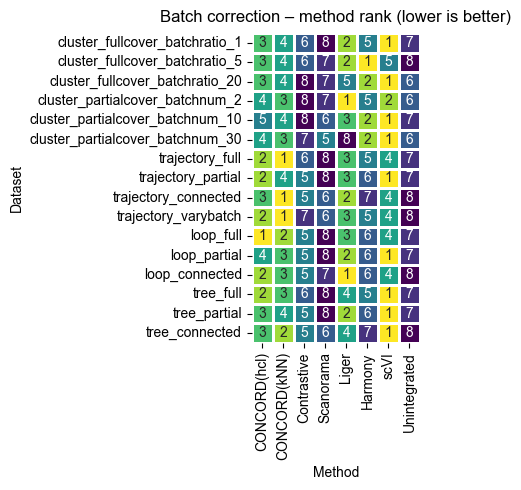

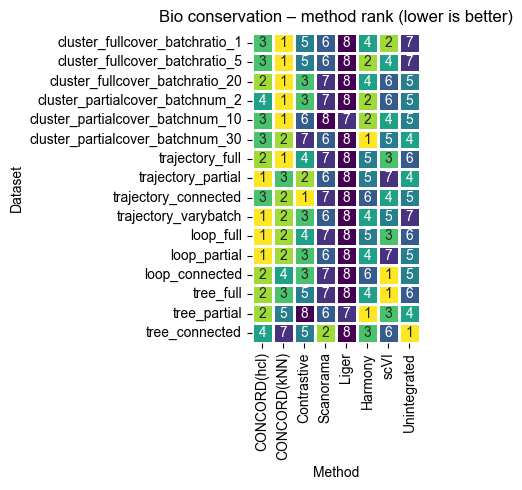

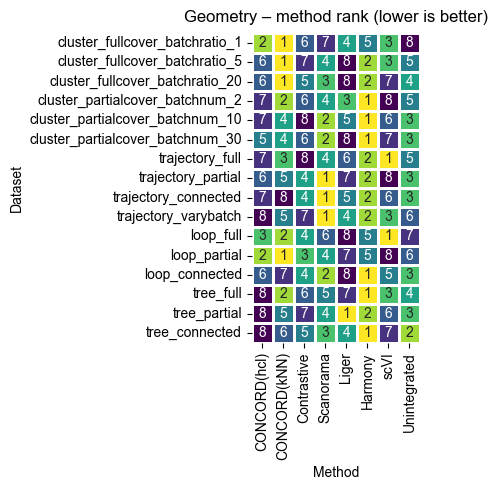

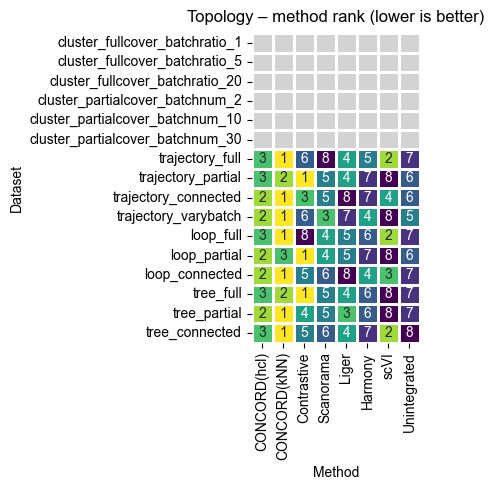

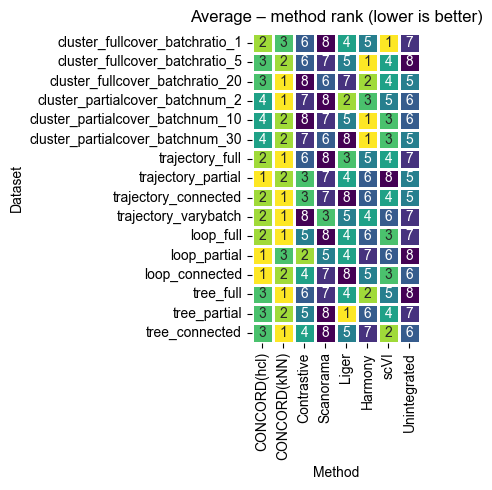

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ── 0. preferences --------------------------------------------------------
concord_methods = ['concord_hcl', 'concord_knn']
other_methods   = [
    'contrastive', 'scanorama', 'liger', 'harmony',
    'scvi', 'unintegrated'
]
subcols = ["Batch correction", "Bio conservation",
           "Geometry", "Topology", "Average"]

cmap = sns.color_palette("viridis_r", as_cmap=True)
cmap.set_bad("lightgrey")          # grey out any remaining NaNs

# ── 1. extract the Aggregate‑score sub‑columns ---------------------------
score_tables = {sub: [] for sub in subcols}

for ds_name, df in bm_results.items():
    for sub in subcols:
        col_key = ("Aggregate score", sub)
        if col_key in df.columns:
            score_tables[sub].append(df[col_key].rename(ds_name))

score_tables = {sub: pd.concat(lst, axis=1)
                for sub, lst in score_tables.items() if lst}

# ── 2. helper: canonical method order ------------------------------------
def sort_methods(index):
    pref = concord_methods + other_methods
    pref = [m for m in pref if m in index]         # keep only existing ones
    the_rest = sorted([m for m in index if m not in pref])
    return pref + the_rest

# ── 3. plot one heat‑map per sub‑score -----------------------------------
# ── 3. plot one heat-map per sub-score -----------------------------------
for sub, table in score_tables.items():

    # a) rank within each dataset (higher score ⇒ rank 1); keep NaNs
    ranked = table.rank(axis=0, ascending=False, method="min", na_option="keep")

    # b) Treat NaN as worst rank for all but Topology
    if sub != "Topology":
        for col in ranked:
            max_rank = ranked[col].max(skipna=True)
            ranked[col] = ranked[col].fillna(max_rank + 1)

    # c) reorder rows so CONCORD variants come first (use original keys)
    ranked = ranked.reindex(sort_methods(ranked.index))

    # c.1) apply display-name mapping for nicer axis labels
    ranked_disp = ranked.copy()
    ranked_disp.index = [method_mapping.get(m, m) for m in ranked.index]

    # d) annotation text: show rank as int; true NaN (Topology) as "–"
    annot = ranked_disp.applymap(lambda v: str(int(v)) if pd.notna(v) else "–")

    # e) plotting
    fig_w, fig_h = 4.4, 5
    with plt.rc_context(rc=custom_rc):
        plt.figure(figsize=(fig_w, fig_h))
        ax = sns.heatmap(
            ranked_disp.T,                # datasets on y-axis; columns are mapped method names
            annot=annot.T,
            fmt="",
            cmap=cmap,                    # cmap.set_bad("lightgrey") already set above
            mask=ranked_disp.T.isna(),    # ensures true NaNs (Topology) render as grey
            linewidths=1,
            linecolor="white",
            cbar=False
        )
        ax.set_title(f"{sub} – method rank (lower is better)", pad=8)
        ax.set_xlabel("Method")
        ax.set_ylabel("Dataset")
        plt.tight_layout()

        fname = sub.lower().replace(" ", "_")
        plt.savefig(save_dir / f"{fname}_rank_{file_suffix}.pdf")
        plt.show()
        plt.close()
